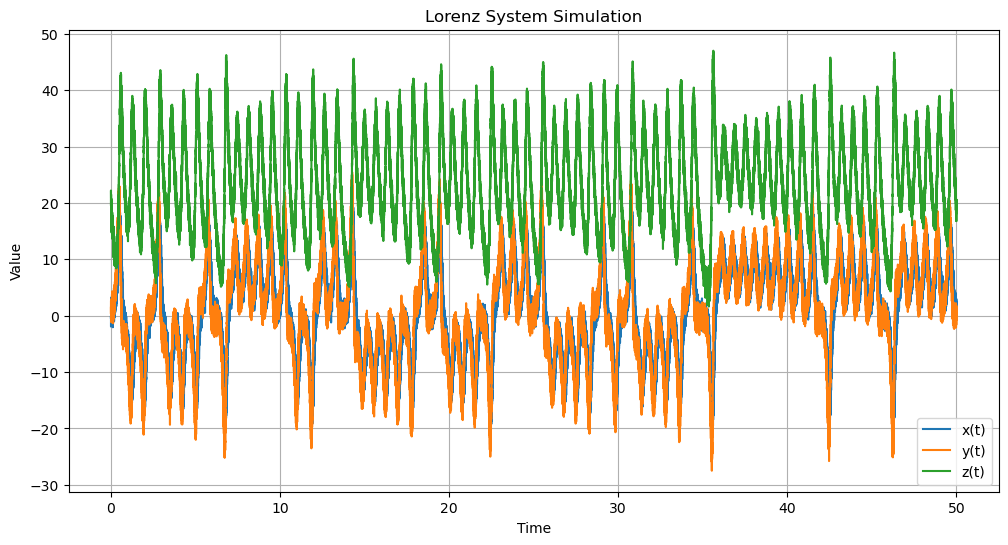

In [97]:
#Simulate and plot a nonlinear time series

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
import matplotlib.pyplot as plt

# Define the Lorenz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Define the Lorenz system equations
def lorenz_system(state, t):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Set the initial conditions and time span
initial_state = [0.0, 1.0, 20.0]
t = np.linspace(0, 50, 50000)  # Time span and number of time steps

# Use an ODE solver to integrate the Lorenz system
from scipy.integrate import odeint
solution = odeint(lorenz_system, initial_state, t)

# Extract the time series for x, y, and z
x = solution[:, 0] + np.random.normal(0, 1, len(solution[:, 0]))
y = solution[:, 1] + np.random.normal(0, 1, len(solution[:, 1]))
z = solution[:, 2] + np.random.normal(0, 1, len(solution[:, 2]))

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(t, x, label='x(t)')
plt.plot(t, y, label='y(t)')
plt.plot(t, z, label='z(t)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Lorenz System Simulation')
plt.legend()
plt.grid()
plt.show()

#Plot the Lorenz attractor in 3D with plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                      mode='markers')])
fig.show()



In [98]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Parameters
input_sequence_length = 500  # Length of the input sequence
output_sequence_length = 500  # Length of the output sequence (target)

# Create input sequences and target sequences
input_sequences = []
target_sequences = []

total_time_steps = len(y)
end_train_index = int(0.7 * total_time_steps)
end_val_index = int(0.8 * total_time_steps)

for i in range(total_time_steps - input_sequence_length - output_sequence_length):
    input_seq = np.column_stack((x[i:i+input_sequence_length], y[i:i+input_sequence_length], z[i:i+input_sequence_length]))
    target_seq = y[i+input_sequence_length:i+input_sequence_length+output_sequence_length]
    input_sequences.append(input_seq)
    target_sequences.append(target_seq)

# Convert the input and target sequences to numpy arrays
input_sequences = np.array(input_sequences)
target_sequences = np.array(target_sequences)

# Split the dataset into training and test sets
X_train = input_sequences[:end_train_index]
y_train = target_sequences[:end_train_index]
X_val = input_sequences[end_train_index:end_val_index]
y_val = target_sequences[end_train_index:end_val_index]
X_test = input_sequences[end_val_index:]
y_test = target_sequences[end_val_index:]

# Define a custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        x = torch.tensor(self.input_sequences[idx], dtype=torch.float32)
        y = torch.tensor(self.target_sequences[idx], dtype=torch.float32)
        return x, y

# Create DataLoader instances for training and test sets
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [99]:
# Define a Feedforward Neural Network that use Relu activation function if linear = False and a linear activation function if linear = True
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, linear):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.linear = linear
        print('Linear Model:', self.linear)
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)


    def forward(self, x):        
        if self.linear == False:
            out = self.relu(self.fc1(x))
            out = self.relu(self.fc2(out))
            out = self.fc3(out)
        else:
            out = self.fc1(x)
            out = self.fc2(out)
            out = self.fc3(out)
        return out


In [100]:
# Define a Feedforward Neural Network
input_size = input_sequence_length * 3  # Each sequence has x, y, z values
hidden_size = 64  # Example hidden layer size
output_size = output_sequence_length

nonlinear_model = FeedforwardNeuralNetwork(input_size, hidden_size, output_size, linear=False)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(nonlinear_model.parameters())  # Using Adam optimizer

# Training Loop with Early Stopping
epochs = 100
patience = 10  # Number of epochs to wait for improvement in validation loss

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Training phase
    nonlinear_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation phase
    nonlinear_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break


Linear Model: False
Epoch 1, Validation Loss: 5.9278675712597595
Epoch 2, Validation Loss: 4.147987440892845
Epoch 3, Validation Loss: 3.9411286168797
Epoch 4, Validation Loss: 3.413326654464576
Epoch 5, Validation Loss: 3.1019008319089365
Epoch 6, Validation Loss: 3.9652702026306446
Epoch 7, Validation Loss: 2.7463768477652484
Epoch 8, Validation Loss: 4.590768784474415
Epoch 9, Validation Loss: 2.4658057477064195
Epoch 10, Validation Loss: 2.513702402448958
Epoch 11, Validation Loss: 2.300594026875344
Epoch 12, Validation Loss: 2.2600238011900786
Epoch 13, Validation Loss: 2.5298238453591706
Epoch 14, Validation Loss: 1.9375470960216157
Epoch 15, Validation Loss: 2.141459012487132
Epoch 16, Validation Loss: 2.6309511638750696
Epoch 17, Validation Loss: 2.2037449642351477
Epoch 18, Validation Loss: 2.0839070423393493
Epoch 19, Validation Loss: 2.326900643907535
Epoch 20, Validation Loss: 2.593424368056522
Epoch 21, Validation Loss: 2.017657527498379
Epoch 22, Validation Loss: 1.965308

In [101]:
# Define a Feedforward Neural Network
input_size = input_sequence_length * 3  # Each sequence has x, y, z values
hidden_size = 64  # Example hidden layer size
output_size = output_sequence_length

linear_model = FeedforwardNeuralNetwork(input_size, hidden_size, output_size, linear=True)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(linear_model.parameters())  # Using Adam optimizer

# Training Loop with Early Stopping
epochs = 100
patience = 10  # Number of epochs to wait for improvement in validation loss

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Training phase
    linear_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = linear_model(inputs.view(inputs.size(0), -1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation phase
    linear_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = linear_model(inputs.view(inputs.size(0), -1))
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Linear Model: True
Epoch 1, Validation Loss: 52.2854083039958
Epoch 2, Validation Loss: 54.544817906276435
Epoch 3, Validation Loss: 61.35500659456678
Epoch 4, Validation Loss: 48.0040605174508
Epoch 5, Validation Loss: 45.23507519892067
Epoch 6, Validation Loss: 53.1294210367142
Epoch 7, Validation Loss: 58.08099313906044
Epoch 8, Validation Loss: 45.71436636159375
Epoch 9, Validation Loss: 50.693833870492924
Epoch 10, Validation Loss: 56.883275782226754
Epoch 11, Validation Loss: 50.7442506923797
Epoch 12, Validation Loss: 52.07165460222086
Epoch 13, Validation Loss: 51.9421245216564
Epoch 14, Validation Loss: 49.4146854285222
Epoch 15, Validation Loss: 54.42514428363484
Early stopping triggered


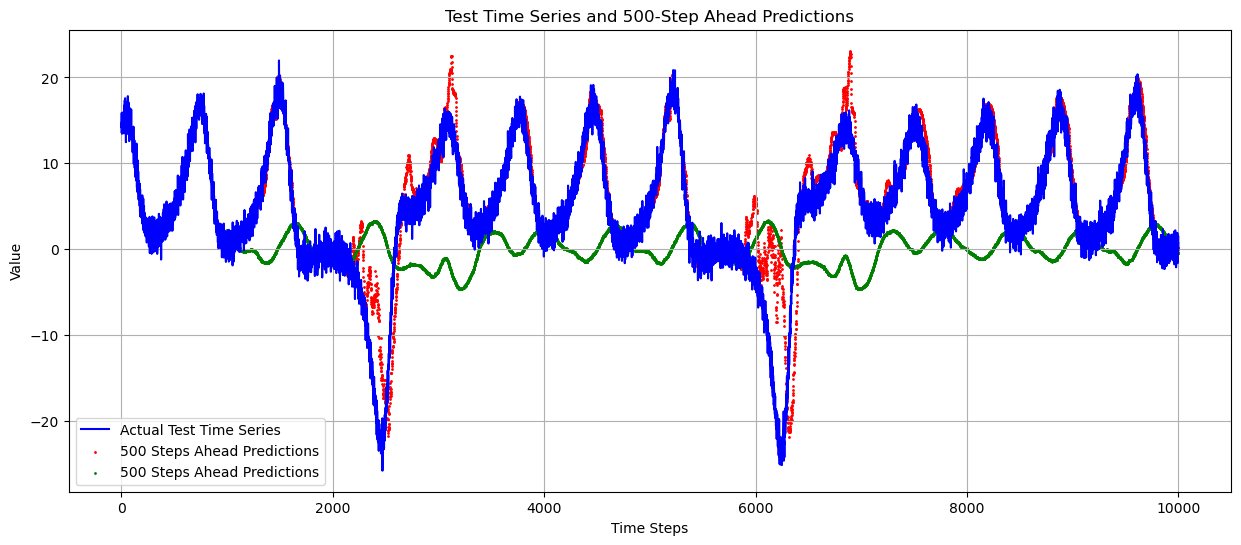

In [102]:
nonlinear_final_step_predictions = []
linear_final_step_predictions = []

nonlinear_model.eval()
linear_model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        nonlinear_outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
        linear_outputs = linear_model(inputs.view(inputs.size(0), -1))
        # Collect the last scalar from each output sequence
        nonlinear_final_step_predictions.extend(nonlinear_outputs[:, -1].numpy())
        linear_final_step_predictions.extend(linear_outputs[:, -1].numpy())



# Adjust prediction_time_steps to align with the test data
prediction_time_steps = np.arange(output_sequence_length + input_sequence_length , len(y) - end_val_index)

plt.figure(figsize=(15, 6))

# Plot all y-values in the test time series
plt.plot(y[end_val_index:], label='Actual Test Time Series', color='blue')

# Overlay the predictions
plt.scatter(prediction_time_steps, nonlinear_final_step_predictions, label='500 Steps Ahead Predictions', color='red', s=1)
plt.scatter(prediction_time_steps, linear_final_step_predictions, label='500 Steps Ahead Predictions', color='green', s=1)

plt.title('Test Time Series and 500-Step Ahead Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()



In [103]:
#Now we want to see how the model is able to predict the time series if we change the amplitude of the data. 
#We will use the same model and the same test data, but we will rescale the data before feeding it to the model and track how the loss changes.
from tqdm import tqdm
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define ranges for scaling and shifting
scale_factors = np.linspace(0.01, 10.0, 10)  # Example range for scale factors
shift_factors = np.linspace(-100, 100, 10)  # Example range for shift factors

# Original test data (assuming X_test, y_test are your test sets)
original_X_test = X_test.copy()
original_y_test = y_test.copy()

# Store the results
scale_values = []
shift_values = []
nonlinear_losses = []
linear_losses = []

# Total number of iterations for the progress bar
total_iterations = len(scale_factors) * len(shift_factors)

# Initialize tqdm progress bar
pbar = tqdm(total=total_iterations, desc='Evaluating', unit='iter')

# Evaluate the model on rescaled data
for scale in scale_factors:
    for shift in shift_factors:
        # Rescale test data
        rescaled_X_test = original_X_test * scale + shift
        rescaled_y_test = original_y_test * scale + shift
        rescaled_test_dataset = CustomDataset(rescaled_X_test, rescaled_y_test)
        rescaled_test_loader = DataLoader(rescaled_test_dataset, batch_size=batch_size, shuffle=False)

        # Make predictions and calculate loss
        nonlinear_model.eval()
        linear_model.eval()
        nonlinear_test_predictions = []
        linear_test_predictions = []
        with torch.no_grad():
            for inputs, targets in rescaled_test_loader:
                # Reshape inputs and make predictions
                nonlinear_outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
                linear_outputs = linear_model(inputs.view(inputs.size(0), -1))
                # Collect the last scalar from each output sequence
                nonlinear_test_predictions.extend(nonlinear_outputs.numpy())
                linear_test_predictions.extend(linear_outputs.numpy())

        # Convert predictions list to numpy array
        nonlinear_test_predictions = np.array(nonlinear_test_predictions)
        linear_test_predictions = np.array(linear_test_predictions)

        # Calculate Mean Squared Error
        nonlinear_loss = mean_squared_error(rescaled_y_test, nonlinear_test_predictions)
        linear_loss = mean_squared_error(rescaled_y_test, linear_test_predictions) 

        # Store results
        scale_values.append(scale)
        shift_values.append(shift)
        nonlinear_losses.append(nonlinear_loss)
        linear_losses.append(linear_loss)

        # Update progress bar
        pbar.update(1)

# Close the progress bar
pbar.close()

# 3D plot of nonlinear loss / linear loss against scaling and shifting factors
# If the ratio is less than 1, make the marker green, otherwise make it red
ratio = [nonlinear_losses[i]/linear_losses[i] for i in range(len(nonlinear_losses))]  
colors = ['green' if r < 1 else 'red' for r in ratio]  
fig = go.Figure(data=[go.Scatter3d(x=scale_values, y=shift_values, z=ratio, mode='markers', marker=dict(color=colors))])
fig.update_layout(scene=dict(xaxis_title='Scale Factor', yaxis_title='Shift Factor', zaxis_title='Loss'))
fig.show()




Evaluating: 100%|██████████| 100/100 [01:03<00:00,  1.58iter/s]


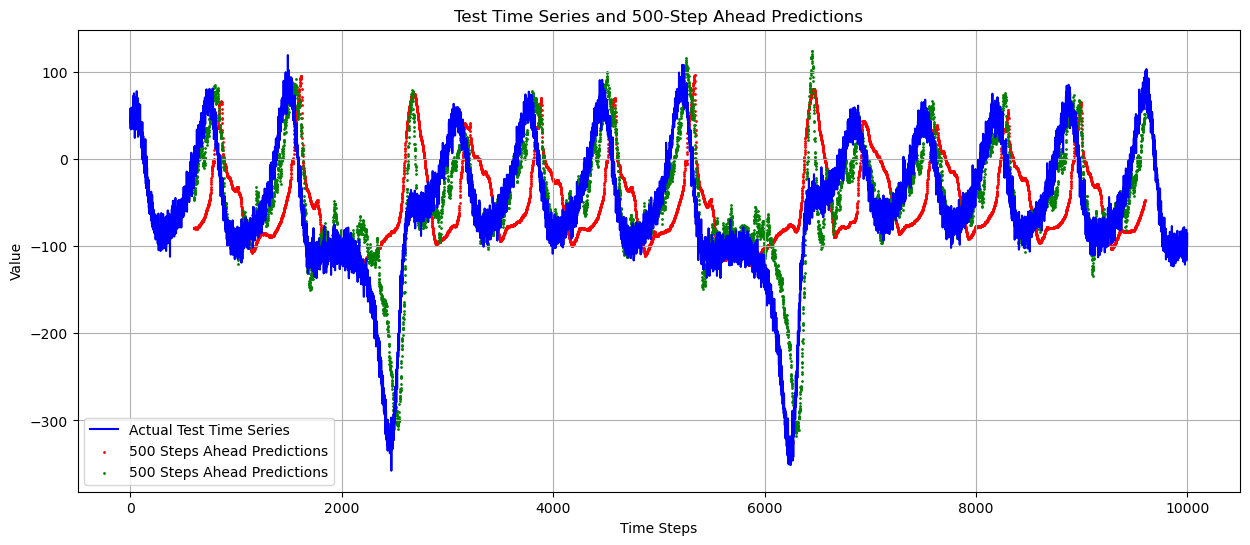

In [104]:
#Plot the k-step ahead predictions for one scaling and shifting factor

scale_factor = 10
shift_factor = -100
k = 100

# Rescale test data
rescaled_X_test = original_X_test * scale_factor + shift_factor
rescaled_y_test = original_y_test * scale_factor + shift_factor
rescaled_test_dataset = CustomDataset(rescaled_X_test, rescaled_y_test)
rescaled_test_loader = DataLoader(rescaled_test_dataset, batch_size=batch_size, shuffle=False)

nonlinear_final_step_predictions = []
linear_final_step_predictions = []

nonlinear_model.eval()
linear_model.eval()

with torch.no_grad():
    for inputs, _ in rescaled_test_loader:
        nonlinear_outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
        linear_outputs = linear_model(inputs.view(inputs.size(0), -1))
        # Collect the last scalar from each output sequence
        nonlinear_final_step_predictions.extend(nonlinear_outputs[:, k-1].numpy())
        linear_final_step_predictions.extend(linear_outputs[:, k-1].numpy())
        


# Adjust prediction_time_steps to align with the test data
prediction_time_steps = np.arange(k + input_sequence_length , len(y) - end_val_index + k - input_sequence_length)

plt.figure(figsize=(15, 6))

# Plot all y-values in the test time series
plt.plot(y[end_val_index:] * scale_factor + shift_factor, label='Actual Test Time Series', color='blue')
# Overlay the predictions
plt.scatter(prediction_time_steps, nonlinear_final_step_predictions, label='500 Steps Ahead Predictions', color='red', s=1)
plt.scatter(prediction_time_steps, linear_final_step_predictions, label='500 Steps Ahead Predictions', color='green', s=1)

plt.title('Test Time Series and 500-Step Ahead Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


In [105]:
#Plot the 20-step ahead predictions for one scaling and shifting factor



In [106]:
#Visualize the input and latent space principal components

#Compute and plot the input space and the output space principal components

from sklearn.decomposition import PCA

output = []
input = []
preds_space=[]
for i in range(0, len(y)-200, 50):
    inputs=y[i:i+200]
    if time:
        inputs=np.append(y[i:i+200], t[i+200:i+250])
        inputs=np.append(inputs, t[i+200:i+250]%1)
    inputs = torch.tensor(inputs)
    outputs =net.encoder(inputs.float())
    preds=net.fc3(outputs)
    output.append(outputs.detach().numpy())
    input.append(inputs.detach().numpy())
    preds_space.append(preds.detach().numpy())

input=np.array(input)
output=np.array(output)
preds_space=np.array(preds_space)

pca = PCA(n_components=2)
pca.fit(input)
input_pca = pca.transform(input)

pca = PCA(n_components=2)
pca.fit(output)
output_pca = pca.transform(output)

pca = PCA(n_components=2)
pca.fit(preds_space)
preds_pca = pca.transform(preds_space)


#plot with plotly in two separate plots

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=input_pca[:,0], y=input_pca[:,1], mode='markers', name='Input Space'))
fig.update_layout(title='Input Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=output_pca[:,0], y=output_pca[:,1], mode='markers', name='Output Space'))
fig.update_layout(title='Output Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=preds_pca[:,0], y=preds_pca[:,1], mode='markers', name='preds Space'))
fig.update_layout(title='Latent Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()






NameError: name 'time' is not defined

In [ ]:
#Visualize the input and latent space principal components after shiftin the input

#Compute and plot the input space and the output space principal components

from sklearn.decomposition import PCA

output = []
input = []
preds_space=[]
for i in range(0, len(y)-200, 50):
    inputs=1000+y[i:i+200]
    if time:
        inputs=np.append(y[i:i+200], t[i+200:i+250])
        inputs=np.append(inputs, t[i+200:i+250]%1)
    inputs = torch.tensor(inputs)
    outputs =net.encoder(inputs.float())
    preds=net.fc3(outputs)
    output.append(outputs.detach().numpy())
    input.append(inputs.detach().numpy())
    preds_space.append(preds.detach().numpy())

input=np.array(input)
output=np.array(output)
preds_space=np.array(preds_space)

pca = PCA(n_components=2)
pca.fit(input)
input_pca = pca.transform(input)

pca = PCA(n_components=2)
pca.fit(output)
output_pca = pca.transform(output)

pca = PCA(n_components=2)
pca.fit(preds_space)
preds_pca = pca.transform(preds_space)


#plot with plotly in two separate plots

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=input_pca[:,0], y=input_pca[:,1], mode='markers', name='Input Space'))
fig.update_layout(title='Input Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=output_pca[:,0], y=output_pca[:,1], mode='markers', name='Output Space'))
fig.update_layout(title='Output Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=preds_pca[:,0], y=preds_pca[:,1], mode='markers', name='preds Space'))
fig.update_layout(title='Latent Space', xaxis_title='PC1', yaxis_title='PC2')
fig.show()

In [ ]:
#Visualize which areas of the mean-variance space are learned by the encoder

import torch
import torch.nn as nn
import numpy as np
import plotly.graph_objects as go

# Input generation
num_samples = 200
input_dim = 200

# Generate some 200-dimensional inputs with random means and variances
inputs = np.array([np.random.normal(1000*(np.random.rand()-0.5), 100*np.random.rand(), input_dim) for _ in range(num_samples)])

# Compute input means and variances
input_means = np.mean(inputs, axis=1)
input_vars = np.std(inputs, axis=1)

# Transfer inputs to tensors
inputs_tensor = torch.from_numpy(inputs.astype(np.float32))

# Apply encoder
encoded = net.encoder(inputs_tensor).detach().numpy()

# Compute means and variances of the encoded data
encoded_means = np.mean(encoded, axis=1)
encoded_vars = np.std(encoded, axis=1)

# Create a scatter plot for the original and encoded data
fig = go.Figure()

# Original data
fig.add_trace(go.Scatter(
    x=input_means, y=input_vars,
    mode='markers',
    name='Original',
    marker=dict(
        size=8,
        color='blue',
        opacity=0.5,
    )
))

# Encoded data
fig.add_trace(go.Scatter(
    x=encoded_means, y=encoded_vars,
    mode='markers',
    name='Encoded',
    marker=dict(
        size=8,
        color='red',
        opacity=0.5,
    )
))

# Add lines connecting original and encoded points
for (x1, y1), (x2, y2) in zip(zip(input_means, input_vars), zip(encoded_means, encoded_vars)):
    fig.add_trace(go.Scatter(
        x=[x1, x2], y=[y1, y2],
        mode='lines',
        line=dict(color='green', width=0.5),
        showlegend=False,
    ))



fig.update_layout(
    title='Mean and Standard Deviation before and after encoding',
    xaxis_title='Mean',
    yaxis_title='Standard Deviation',
    legend=dict(
        y=0.2,
        traceorder='reversed',
        font=dict(
            size=16,
        )
    )
)

fig.show()
